# ANP Forecasting de Preços de Combustiveis

### Carregamento de Dados

In [23]:
# Carregamento de bibliotecas
import pandas as pd
import sys
sys.path.append('../Utils')

import matplotlib.pyplot as plt

import plot_functions as plot
import tratamento_de_dados as transform

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [2]:
# Carregamento de dados
url_data = "https://raw.githubusercontent.com/AurelioGuilherme/ANP-ETL/refs/heads/main/Data/Data-silver/dados_combustiveis_anp.csv"
df = pd.read_csv(url_data)
df.head()

,DATA INICIAL,DATA FINAL,ESTADO,MUNICÍPIO,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,COEF DE VARIAÇÃO REVENDA,periodo_referencia
0,2023-08-27 00:00:00,2023-09-02 00:00:00,SERGIPE,ARACAJU,ETANOL HIDRATADO,16,R$/l,4.79,0.095708,4.57,4.89,0.020,2023-08-27 a 2023-09-02
1,2023-08-27 00:00:00,2023-09-02 00:00:00,PARA,BELEM,ETANOL HIDRATADO,7,R$/l,4.66,0.328655,4.29,5.19,0.071,2023-08-27 a 2023-09-02
2,2023-08-27 00:00:00,2023-09-02 00:00:00,MINAS GERAIS,BELO HORIZONTE,ETANOL HIDRATADO,40,R$/l,3.50,0.108223,3.34,3.79,0.031,2023-08-27 a 2023-09-02
3,2023-08-27 00:00:00,2023-09-02 00:00:00,RORAIMA,BOA VISTA,ETANOL HIDRATADO,4,R$/l,4.94,0.140000,4.87,5.15,0.028,2023-08-27 a 2023-09-02
4,2023-08-27 00:00:00,2023-09-02 00:00:00,DISTRITO FEDERAL,BRASILIA,ETANOL HIDRATADO,49,R$/l,3.77,0.142499,3.58,3.99,0.038,2023-08-27 a 2023-09-02


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11816 entries, 0 to 11815
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DATA INICIAL                  11816 non-null  object 
 1   DATA FINAL                    11816 non-null  object 
 2   ESTADO                        11816 non-null  object 
 3   MUNICÍPIO                     11816 non-null  object 
 4   PRODUTO                       11816 non-null  object 
 5   NÚMERO DE POSTOS PESQUISADOS  11816 non-null  int64  
 6   UNIDADE DE MEDIDA             11816 non-null  object 
 7   PREÇO MÉDIO REVENDA           11816 non-null  float64
 8   DESVIO PADRÃO REVENDA         11816 non-null  float64
 9   PREÇO MÍNIMO REVENDA          11816 non-null  float64
 10  PREÇO MÁXIMO REVENDA          11816 non-null  float64
 11  COEF DE VARIAÇÃO REVENDA      11816 non-null  float64
 12  periodo_referencia            11816 non-null  object 
dtypes

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
NÚMERO DE POSTOS PESQUISADOS,11816.0,23.649120,28.015003,1.00,9.000000,17.00000,29.000000,210.000000
PREÇO MÉDIO REVENDA,11816.0,21.477609,36.954022,2.80,5.280000,5.95000,6.450000,137.300000
DESVIO PADRÃO REVENDA,11816.0,1.242986,2.707259,0.00,0.085004,0.16529,0.317528,14.972444
PREÇO MÍNIMO REVENDA,11816.0,19.362084,32.695987,2.39,4.990000,5.68000,6.260000,130.000000
PREÇO MÁXIMO REVENDA,11816.0,24.262389,42.565950,2.95,5.590000,6.29000,6.990000,160.000000
COEF DE VARIAÇÃO REVENDA,11816.0,0.035986,0.028131,0.00,0.015000,0.03000,0.050000,0.150000


### Tratamento de Dados

In [5]:
df_filtrado = transform.filtra_dados(df, 'sergipe', 'ETANOL HIDRATADO')
df_filtrado.head()

,DATA INICIAL,DATA FINAL,ESTADO,MUNICÍPIO,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,COEF DE VARIAÇÃO REVENDA,periodo_referencia
0,2023-08-27 00:00:00,2023-09-02 00:00:00,SERGIPE,ARACAJU,ETANOL HIDRATADO,16,R$/l,4.79,0.095708,4.57,4.89,0.020,2023-08-27 a 2023-09-02
172,2023-09-03 00:00:00,2023-09-09 00:00:00,SERGIPE,ARACAJU,ETANOL HIDRATADO,17,R$/l,4.81,0.101297,4.57,4.89,0.021,2023-09-03 a 2023-09-09
343,2023-09-10 00:00:00,2023-09-16 00:00:00,SERGIPE,ARACAJU,ETANOL HIDRATADO,17,R$/l,4.79,0.111688,4.57,4.89,0.023,2023-09-10 a 2023-09-16
510,2023-09-17 00:00:00,2023-09-23 00:00:00,SERGIPE,ARACAJU,ETANOL HIDRATADO,16,R$/l,4.73,0.102038,4.57,4.89,0.022,2023-09-17 a 2023-09-23
676,2023-09-24 00:00:00,2023-09-30 00:00:00,SERGIPE,ARACAJU,ETANOL HIDRATADO,17,R$/l,4.78,0.060513,4.70,4.89,0.013,2023-09-24 a 2023-09-30


In [6]:
df_filtrado = transform.seleciona_features(df_filtrado, 
                                           features=[
                                               'DATA INICIAL',
                                               'NÚMERO DE POSTOS PESQUISADOS',
                                               'PRODUTO',
                                               'ESTADO',
                                               'PREÇO MÉDIO REVENDA'
                                           ])

df_filtrado.head()

,DATA INICIAL,NÚMERO DE POSTOS PESQUISADOS,PRODUTO,ESTADO,PREÇO MÉDIO REVENDA
0,2023-08-27 00:00:00,16,ETANOL HIDRATADO,SERGIPE,4.79
172,2023-09-03 00:00:00,17,ETANOL HIDRATADO,SERGIPE,4.81
343,2023-09-10 00:00:00,17,ETANOL HIDRATADO,SERGIPE,4.79
510,2023-09-17 00:00:00,16,ETANOL HIDRATADO,SERGIPE,4.73
676,2023-09-24 00:00:00,17,ETANOL HIDRATADO,SERGIPE,4.78


In [7]:
df_filtrado = transform.trata_datas(df_filtrado, 'DATA INICIAL')
df_filtrado

,DATA INICIAL,NÚMERO DE POSTOS PESQUISADOS,PRODUTO,ESTADO,PREÇO MÉDIO REVENDA
0,2023-08-27,16,ETANOL HIDRATADO,SERGIPE,4.79
172,2023-09-03,17,ETANOL HIDRATADO,SERGIPE,4.81
343,2023-09-10,17,ETANOL HIDRATADO,SERGIPE,4.79
510,2023-09-17,16,ETANOL HIDRATADO,SERGIPE,4.73
676,2023-09-24,17,ETANOL HIDRATADO,SERGIPE,4.78
...,...,...,...,...,...
10977,2024-12-15,14,ETANOL HIDRATADO,SERGIPE,4.31
11142,2025-01-05,12,ETANOL HIDRATADO,SERGIPE,4.36
11307,2025-01-12,12,ETANOL HIDRATADO,SERGIPE,4.60
11478,2025-01-19,12,ETANOL HIDRATADO,SERGIPE,4.65


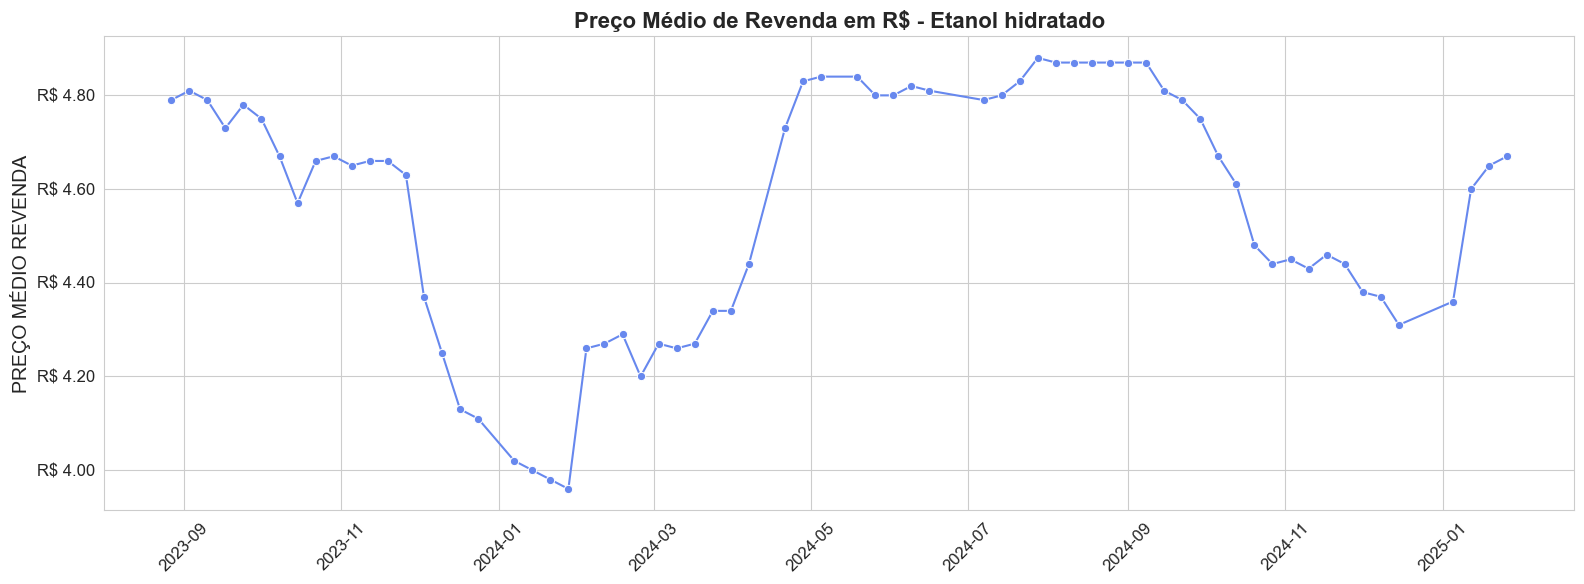

In [8]:
plot.visualiza_serie_temporal(df_filtrado, x='DATA INICIAL', y='PREÇO MÉDIO REVENDA')

In [9]:
serie_temporal = transform.cria_df_serie_temporal(df_filtrado)
serie_temporal.head()

,preco
Data,
2023-08-27,4.79
2023-09-03,4.81
2023-09-10,4.79
2023-09-17,4.73
2023-09-24,4.78


In [10]:
serie_temporal['preco']

Data
2023-08-27    4.79
2023-09-03    4.81
2023-09-10    4.79
2023-09-17    4.73
2023-09-24    4.78
              ... 
2024-12-15    4.31
2025-01-05    4.36
2025-01-12    4.60
2025-01-19    4.65
2025-01-26    4.67
Name: preco, Length: 68, dtype: float64

In [11]:
resultado = seasonal_decompose(serie_temporal['preco'],model = 'additive', period=7)

<Figure size 640x480 with 0 Axes>

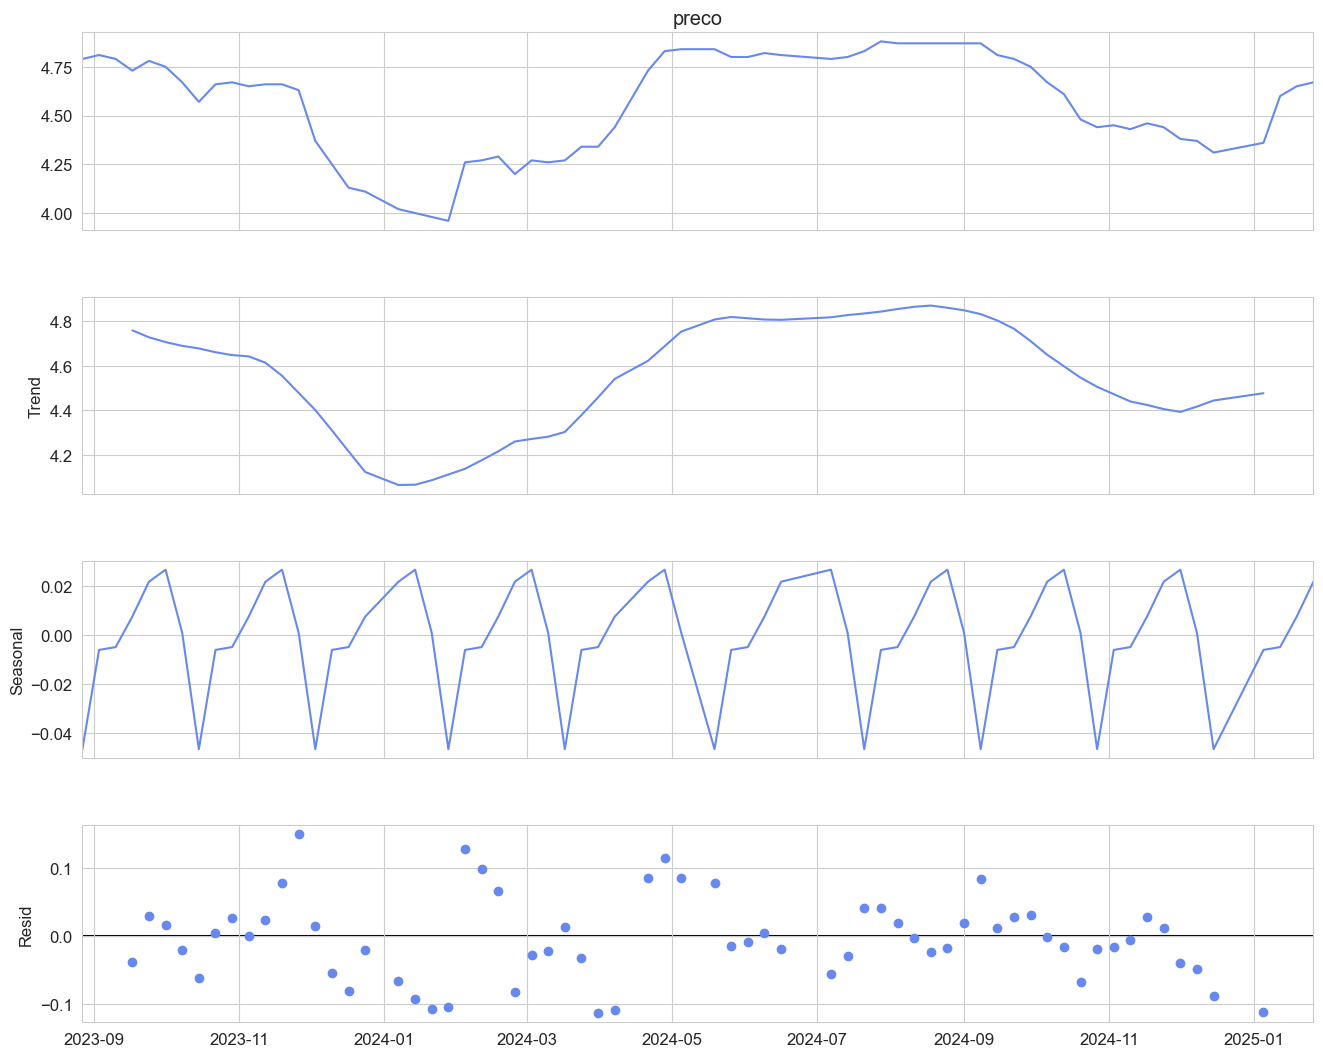

In [12]:
# Plot
fig = plt.figure()  
fig = resultado.plot()  
fig.set_size_inches(15, 12);



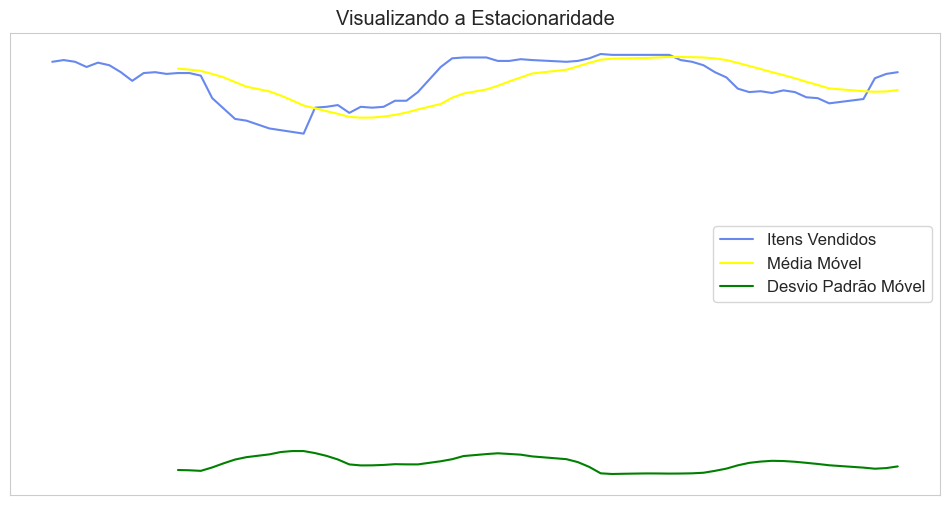

In [13]:
# Aplica a função
plot.visualiza_estacionaridade(serie_temporal)

In [14]:
# Aplica o teste
resultado_adft = adfuller(serie_temporal)
resultado_adft

(np.float64(-1.9448211490336722),
 np.float64(0.31127828046100336),
 1,
 66,
 {'1%': np.float64(-3.5335601309235605),
  '5%': np.float64(-2.9064436883991434),
  '10%': np.float64(-2.590723948576676)},
 np.float64(-118.28713928589096))

In [15]:
# Resultado
if resultado_adft[1] < 0.05:
    print('O valor-p é menor que 0.05. Podemos rejeitar a H0. A série é estacionária.')
else:
    print('O valor-p é maior que 0.05. Não podemos rejeitar a H0. A série não é estacionária.')

O valor-p é maior que 0.05. Não podemos rejeitar a H0. A série não é estacionária.


In [16]:
# Aplica a diferenciação
first_diff = serie_temporal.preco - serie_temporal.preco.shift(1)

In [17]:
# Remove valores NA gerados no processo
first_diff = first_diff.dropna()

In [18]:
first_diff = pd.DataFrame(first_diff)

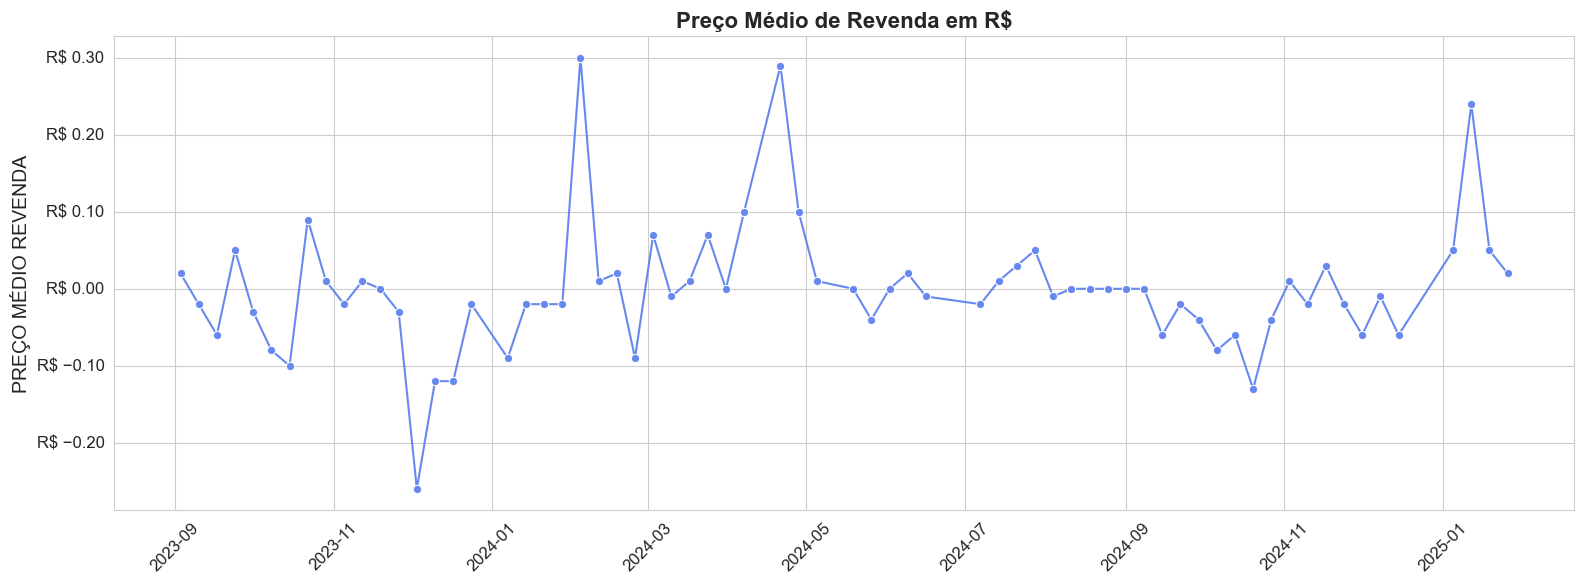

In [19]:
plot.visualiza_serie_temporal(first_diff, x = first_diff.index, y= first_diff.preco, produto=False)

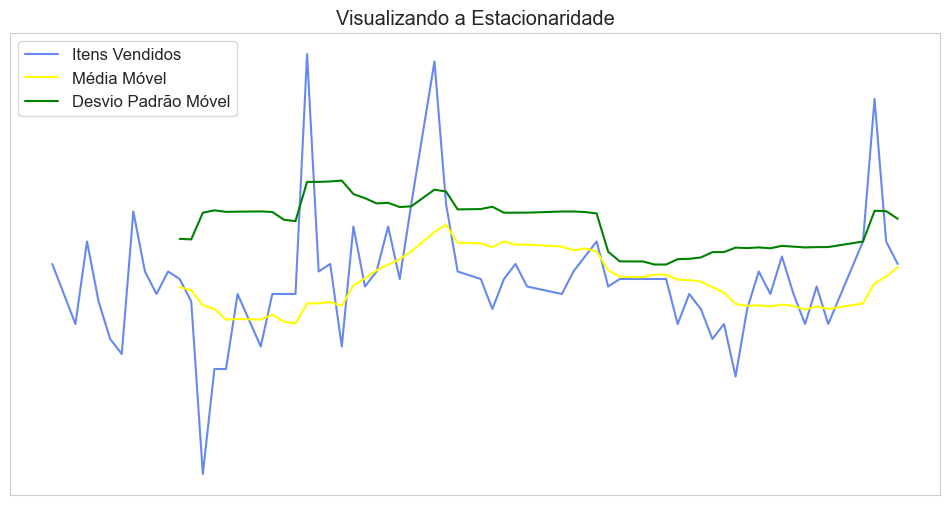

In [20]:
plot.visualiza_estacionaridade(first_diff)

In [22]:
# Aplica o teste
resultado_adft = adfuller(first_diff)

# Resultado
if resultado_adft[1] < 0.05:
    print('O valor-p é menor que 0.05. Podemos rejeitar a H0. A série é estacionária.')
else:
    print('O valor-p é maior que 0.05. Não podemos rejeitar a H0. A série não é estacionária.')

O valor-p é menor que 0.05. Podemos rejeitar a H0. A série é estacionária.


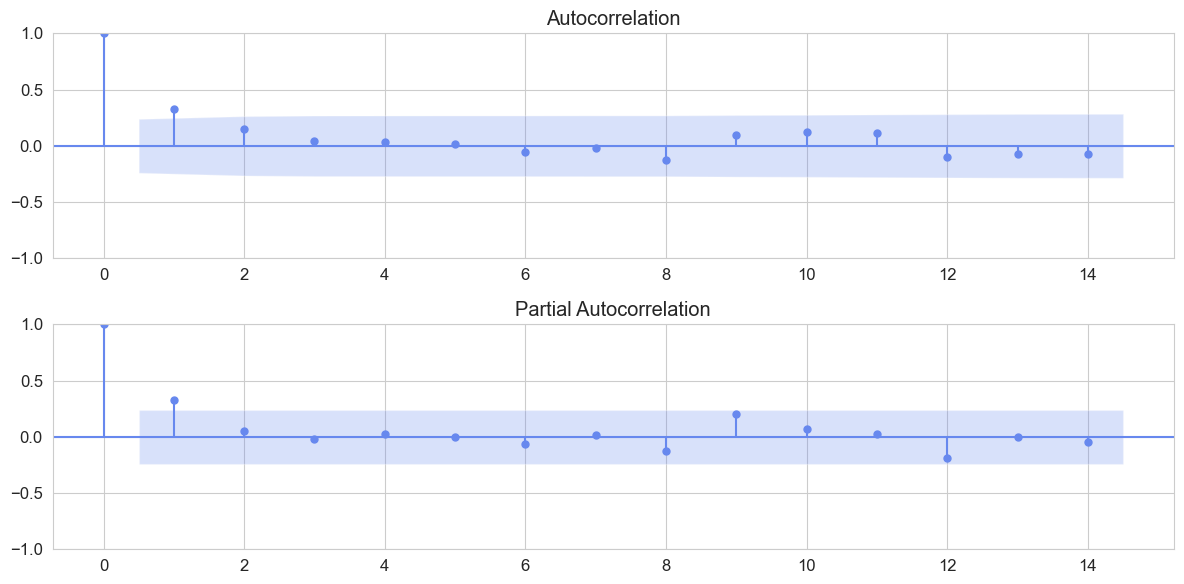

In [27]:
# Plot
fig, axes = plt.subplots(2, figsize = (12,6))
axes[0] = plot_acf(first_diff, ax = axes[0], lags = 14)
axes[1] = plot_pacf(first_diff, ax = axes[1], lags = 14)
plt.tight_layout()

plt.show()

### Modelagem

### Validação